## Convolution Neural Network
1) Sample code
2) Five different cnn configs - create comparison table
3) Visualize filters and features
4) Alexnet (Optional)
5) Build own cnn model and use on custom dataset
6) Compare fully connected and CNN


# Deep Learning Lab 4 - Convolution Neural Network
>Ankith Motha
>21BAI1284

### 1) Execute Sample Convolution Neural Network Code

In [1]:
import numpy 
import tensorflow as tf
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.utils import to_categorical
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
seed = 7 
numpy.random.seed(seed) 
# load data 
(X_train, y_train), (X_test, y_test) = mnist.load_data() 
# reshape to be [samples][channels][width][height] 
X_train = X_train.reshape(X_train.shape[0], 28, 28,1).astype( 'float32' ) 
X_test = X_test.reshape(X_test.shape[0], 28, 28,1).astype( 'float32' ) 
# normalize inputs from 0-255 to 0-1 
X_train = X_train / 255 
X_test = X_test / 255 


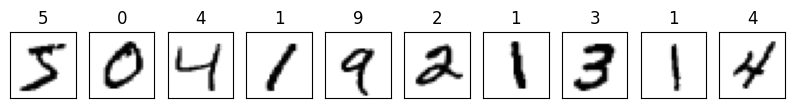

In [3]:
import numpy 
# one hot encode outputs 
y_train = to_categorical(y_train) 
y_test = to_categorical(y_test) 
num_classes = y_test.shape[1] 
(x_train, y_train1), (x_test, y_test1) = mnist.load_data() 
fig, ax = plt.subplots(1, 10, figsize=(10,10)) 
for i in range(0, 10): 
	ax[i].xaxis.set_visible(False) 
	ax[i].yaxis.set_visible(False) 
	ax[i].set_title(y_train1[i]) 
	ax[i].imshow(x_train[i], cmap=plt.cm.binary) 


In [4]:
def baseline_model(): 
    # create model 
    model = Sequential() 
    model.add(Conv2D(32, (5, 5), padding= 'valid' ,strides=(1,1), input_shape=( 28, 28,1), 
    activation= 'relu' )) 
    model.add(MaxPool2D(pool_size=(2, 2))) 
    model.add(Dropout(0.2)) 
    model.add(Flatten()) 
    model.add(Dense(1152, activation= 'relu' )) 
    model.add(Dense(128, activation= 'relu' )) 
    model.add(Dense(10, activation= 'softmax' ))
    # Compile model 
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ]) 
    return model 


model = baseline_model() 
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200) 
scores = model.evaluate(X_test, y_test) 
print("CNN Error: %.2f%%" % (100-scores[1]*100)) 






Epoch 1/10


300/300 [==============================] - 28s 90ms/step - loss: 0.1775 - accuracy: 0.9457 - val_loss: 0.0613 - val_accuracy: 0.9809
Epoch 2/10
300/300 [==============================] - 25s 85ms/step - loss: 0.0523 - accuracy: 0.9839 - val_loss: 0.0358 - val_accuracy: 0.9886
Epoch 3/10
300/300 [==============================] - 24s 81ms/step - loss: 0.0332 - accuracy: 0.9893 - val_loss: 0.0336 - val_accuracy: 0.9881
Epoch 4/10
300/300 [==============================] - 24s 81ms/step - loss: 0.0220 - accuracy: 0.9925 - val_loss: 0.0287 - val_accuracy: 0.9916
Epoch 5/10
300/300 [==============================] - 21s 71ms/step - loss: 0.0182 - accuracy: 0.9940 - val_loss: 0.0344 - val_accuracy: 0.9883
Epoch 6/10
300/300 [==============================] - 20s 65ms/step - loss: 0.0132 - accuracy: 0.9956 - val_loss: 0.0419 - val_accuracy: 0.9873
Epoch 7/10
300/300 [==============================] - 20s 66ms/step - loss: 0.0111 - accuracy: 0.9964 - val_loss: 0.0396 - val_accu

### 2) Convolution Neural Network Configurations and Comparison

In [39]:
import torch
from torch.nn import Module
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from tqdm import tqdm
import torchsummary

torch.__version__

'2.2.0+cpu'

In [28]:
# HYPERPARAMETERS
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 0.001
NCLASSES = 10

train_data = datasets.MNIST(root="data",train=True,download=True,transform=transforms.ToTensor())
train_dataloader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)
test_data = datasets.MNIST(root="data",train=False,download=True,transform=transforms.ToTensor())
test_dataloader = DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=False)

In [35]:
class CNN(Module):
    def __init__(self, num_classes=NCLASSES,CNNkernel=(3,3),CNNstride=(1,1),Maxkernel=(2,2),Maxstride=(2,2)):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=CNNkernel, padding=(1,1), stride=CNNstride)
        self.pool = torch.nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=CNNkernel,padding=(1,1), stride=CNNstride)
        self.fc1 = torch.nn.LazyLinear(num_classes)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x) 
        return x

In [36]:
#CNN Variations
configs = [dict(CNNkernel=(3,3),CNNstride=(1,1)),
           dict(CNNkernel=(5,5),CNNstride=(1,1)),
           dict(CNNkernel=(3,3),CNNstride=(3,3))]

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

configs

[{'CNNkernel': (3, 3), 'CNNstride': (1, 1)},
 {'CNNkernel': (5, 5), 'CNNstride': (1, 1)},
 {'CNNkernel': (3, 3), 'CNNstride': (3, 3)}]

In [38]:
outputs = []

for num,d in enumerate(configs):
    model = CNN(CNNkernel=d['CNNkernel'],CNNstride=d['CNNstride'])
    # Loss and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train Network
    for epoch in range(EPOCHS):
        for batch_idx, (data, targets) in enumerate(train_dataloader):
            # forward
            scores = model(data)
            loss = criterion(scores, targets)

            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()
    
    train_acc = check_accuracy(train_dataloader, model)*100
    test_acc = check_accuracy(test_dataloader, model)*100
    print(f"Accuracy on training set: {train_acc:.2f}")
    print(f"Accuracy on test set: {test_acc:.2f}")
    res = {f"model{num+1}":model,f"config{num+1}":d,"train_acc":train_acc,"test_acc":test_acc}
    outputs.append(res)


d:\Software\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Accuracy on training set: 99.84
Accuracy on test set: 99.13
Accuracy on training set: 99.88
Accuracy on test set: 99.19
Accuracy on training set: 98.36
Accuracy on test set: 97.18


In [ ]:
outputs

### 3) Visualize Kernels and Feature maps of a CNN

In [40]:
model_viz = CNN()
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_viz.parameters(), lr=0.001)

# Train Network
for epoch in range(EPOCHS):
    for batch_idx, (data, targets) in enumerate(tqdm(train_dataloader)):
        # forward
        scores = model_viz(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

train_acc = check_accuracy(train_dataloader, model_viz)*100
test_acc = check_accuracy(test_dataloader, model_viz)*100
print(f"Accuracy on training set: {train_acc:.2f}")
print(f"Accuracy on test set: {test_acc:.2f}")

d:\Software\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 3750/3750 [00:34<00:00, 109.88it/s]


Accuracy on training set: 99.81
Accuracy on test set: 99.07


In [45]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model_viz.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == torch.nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == torch.nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == torch.nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 2
conv_layers


In [54]:
image = train_data[0][0]
image = image.unsqueeze(0)
outputs = []
names = []
for layer in conv_layers[0:]:
    print(layer)
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2
torch.Size([1, 32, 28, 28])
torch.Size([1, 64, 28, 28])


In [55]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(28, 28)
(28, 28)


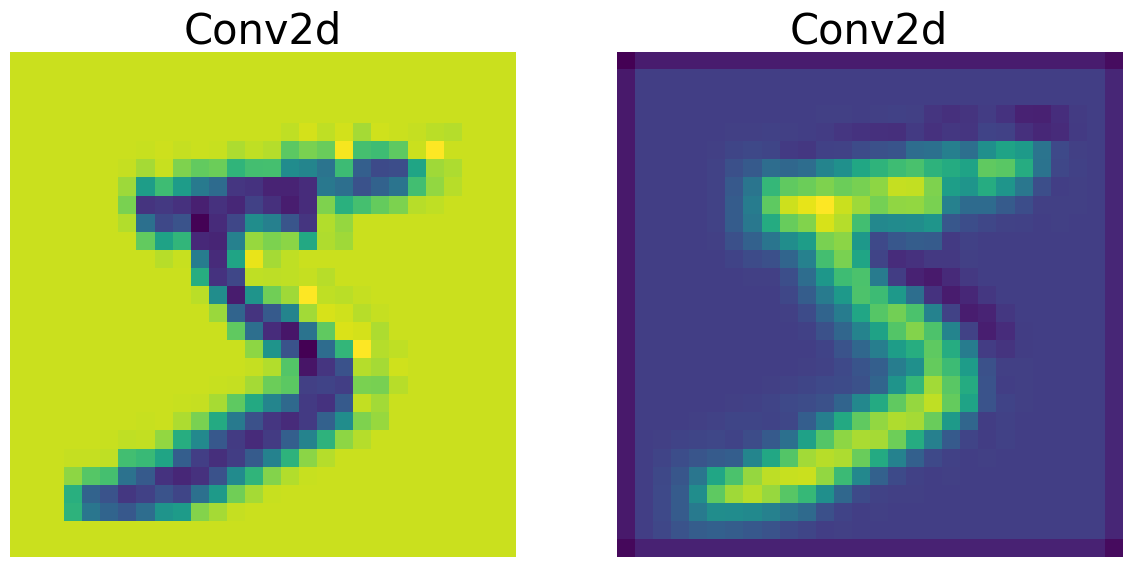

In [56]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

### 3b) Visualize Kernels

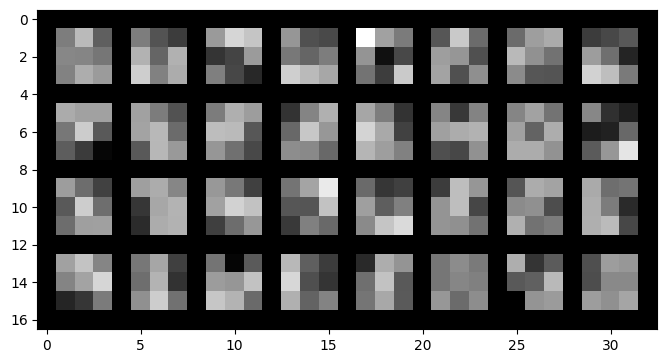

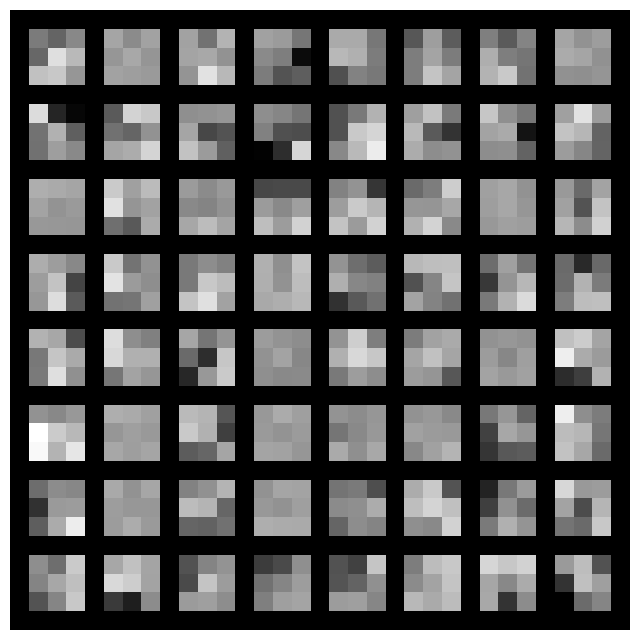

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


if __name__ == "__main__":
    filter1 = model_viz.conv1.weight.data.clone()
    visTensor(filter1, ch=0, allkernels=False)
    
    filter2 = model_viz.conv2.weight.data.clone()
    visTensor(filter2, ch=0, allkernels=False)

    plt.axis('off')
    plt.ioff()
    plt.show()

### 4) Create a CNN Model on Custom Dataset
>Dataset: Cats and Dogs

In [61]:
# Load Data

TRAIN_PATH = "./Datasets/Cats_Dogs_Kaggle/training_set"
TEST_PATH = "./Datasets/Cats_Dogs_Kaggle/test_set"

train_data = datasets.ImageFolder(root=TRAIN_PATH, transform=transforms.ToTensor())
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_data = datasets.ImageFolder(root=TEST_PATH, transform=transforms.ToTensor())
test_data_loader  = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)


In [66]:
class CustomCNN(Module):
    def __init__(self, num_classes=NCLASSES,CNNkernel=(3,3),CNNstride=(1,1)):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=CNNkernel, padding=(1,1), stride=CNNstride)
        self.pool = torch.nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=CNNkernel,padding=(1,1), stride=CNNstride)
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=CNNkernel,padding=(1,1), stride=CNNstride)
        self.fc1 = torch.nn.LazyLinear(512)
        self.fc2 = torch.nn.Linear(512,num_classes)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.dropout(x,0.3)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [67]:
model = CustomCNN()
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train Network
for epoch in range(5):
    for batch_idx, (data, targets) in enumerate(tqdm(train_dataloader)):
        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

train_acc = check_accuracy(train_dataloader, model)*100
test_acc = check_accuracy(test_dataloader, model)*100
print(f"Accuracy on training set: {train_acc:.2f}")
print(f"Accuracy on test set: {test_acc:.2f}")

d:\Software\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 3750/3750 [01:02<00:00, 60.18it/s]


Accuracy on training set: 99.03
Accuracy on test set: 98.37


### 5) Compare Fully Connected NN and CNN

In [68]:
class FCNN(Module):
    def __init__(self, num_classes=NCLASSES,CNNkernel=(3,3),CNNstride=(1,1)):
        super().__init__()
        self.fc1 = torch.nn.Linear(784,512)
        self.fc2 = torch.nn.Linear(512,512)
        self.fc3 = torch.nn.Linear(512,256)
        self.fc4 = torch.nn.Linear(256,128)
        self.fc5 = torch.nn.Linear(128,num_classes)
    
    def forward(self,x):
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.softmax(self.fc5(x))
        return x

In [ ]:
model_fcnn = FCNN()
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fcnn.parameters(), lr=0.001)

train_losses = []
val_losses = []

# Train Network
for epoch in range(5):
    for batch_idx, (data, targets) in enumerate(tqdm(train_dataloader)):
        # forward
        scores = model_fcnn(data)
        loss = criterion(scores, targets)
        train_losses.append(loss)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

train_acc = check_accuracy(train_dataloader, model_fcnn)*100
test_acc = check_accuracy(test_dataloader, model_fcnn)*100
print(f"Accuracy on training set: {train_acc:.2f}")
print(f"Accuracy on test set: {test_acc:.2f}")

In [77]:
ls = []
for i in train_losses:
    ls.append(i.detach().numpy())
ls[0]

array(2.3018582, dtype=float32)

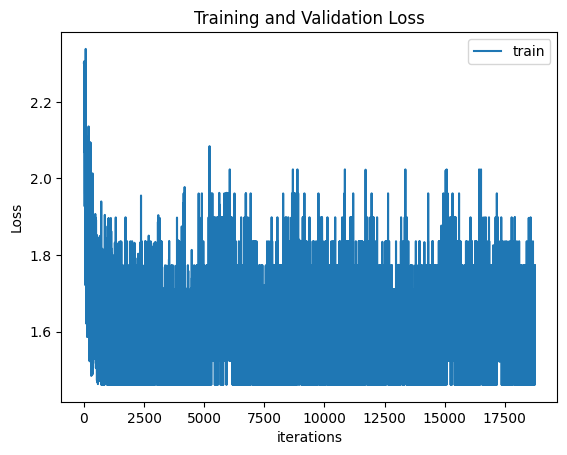

In [79]:
plt.title("Training and Validation Loss")
plt.plot(ls,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [80]:
model = CustomCNN()
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []

# Train Network
for epoch in range(5):
    for batch_idx, (data, targets) in enumerate(tqdm(train_dataloader)):
        # forward
        scores = model(data)
        loss = criterion(scores, targets)
        train_losses.append(loss)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

train_acc = check_accuracy(train_dataloader, model)*100
test_acc = check_accuracy(test_dataloader, model)*100
print(f"Accuracy on training set: {train_acc:.2f}")
print(f"Accuracy on test set: {test_acc:.2f}")




d:\Software\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 3750/3750 [00:52<00:00, 71.59it/s]


Accuracy on training set: 99.07
Accuracy on test set: 98.60


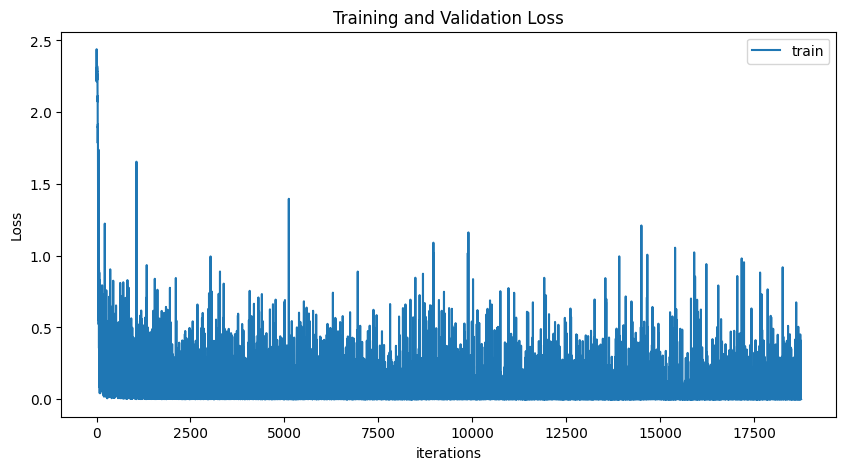

In [81]:
ls = []
for i in train_losses:
    ls.append(i.detach().numpy())
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(ls,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()